# Imports

In [0]:
import torch
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Network Architecture

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.out = nn.Linear(64,10)
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.out(x), dim = 1)
    return x
  

In [5]:
model = Classifier()
images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:

epochs = 10
train_losses = []
test_losses = []
for epoch in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    
    log_ps = model.forward(images)
    loss = criterion(log_ps, labels)
    
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      for images, labels in testloader:
        log_ps = model.forward(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        _,top_class = ps.topk(1,dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
           "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
           "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
           "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
        
        
        
        
    
    

Epoch: 1/10..  Training Loss: 0.321..  Test Loss: 0.364..  Test Accuracy: 0.869
Epoch: 2/10..  Training Loss: 0.307..  Test Loss: 0.359..  Test Accuracy: 0.873
Epoch: 3/10..  Training Loss: 0.290..  Test Loss: 0.350..  Test Accuracy: 0.873
Epoch: 4/10..  Training Loss: 0.282..  Test Loss: 0.367..  Test Accuracy: 0.871
Epoch: 5/10..  Training Loss: 0.274..  Test Loss: 0.370..  Test Accuracy: 0.871
Epoch: 6/10..  Training Loss: 0.264..  Test Loss: 0.347..  Test Accuracy: 0.880
Epoch: 7/10..  Training Loss: 0.256..  Test Loss: 0.352..  Test Accuracy: 0.879
Epoch: 8/10..  Training Loss: 0.249..  Test Loss: 0.365..  Test Accuracy: 0.875
Epoch: 9/10..  Training Loss: 0.242..  Test Loss: 0.343..  Test Accuracy: 0.879
Epoch: 10/10..  Training Loss: 0.238..  Test Loss: 0.343..  Test Accuracy: 0.884


In [0]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

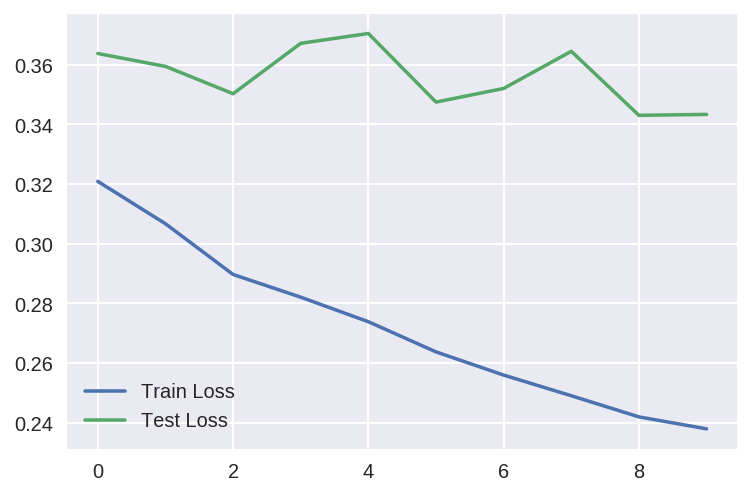

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend(frameon = False)

## Dropouts

In [0]:
class classifier2(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.out = nn.Linear(64,10)
    self.dropout = nn.Dropout(p=0.2)
    
  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.out(x), dim = 1)
    return x

In [28]:
model = classifier2()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
criterion = nn.NLLLoss()
model

classifier2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [29]:
%%time
epochs = 10
train_losses, test_losses = [],[]
for epoch in range(epochs):
  running_loss = 0
  for images,labels in trainloader:
    optimizer.zero_grad()
    
    log_ps = model.forward(images)
    train_loss = criterion(log_ps,labels)
    
    train_loss.backward()
    optimizer.step()
    
    running_loss += train_loss.item()
  else:
    accuracy = 0
    test_loss = 0
    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)
        
        ps = torch.exp(log_ps)
        _,top_class = ps.topk(1,dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    model.train()
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
           "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
           "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
           "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

Epoch: 1/10..  Training Loss: 0.596..  Test Loss: 0.457..  Test Accuracy: 0.838
Epoch: 2/10..  Training Loss: 0.451..  Test Loss: 0.425..  Test Accuracy: 0.842
Epoch: 3/10..  Training Loss: 0.418..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 4/10..  Training Loss: 0.397..  Test Loss: 0.412..  Test Accuracy: 0.851
Epoch: 5/10..  Training Loss: 0.384..  Test Loss: 0.393..  Test Accuracy: 0.861
Epoch: 6/10..  Training Loss: 0.379..  Test Loss: 0.370..  Test Accuracy: 0.868
Epoch: 7/10..  Training Loss: 0.372..  Test Loss: 0.373..  Test Accuracy: 0.867
Epoch: 8/10..  Training Loss: 0.366..  Test Loss: 0.387..  Test Accuracy: 0.862
Epoch: 9/10..  Training Loss: 0.359..  Test Loss: 0.373..  Test Accuracy: 0.870
Epoch: 10/10..  Training Loss: 0.352..  Test Loss: 0.402..  Test Accuracy: 0.860
CPU times: user 2min 44s, sys: 2.86 s, total: 2min 47s
Wall time: 2min 47s


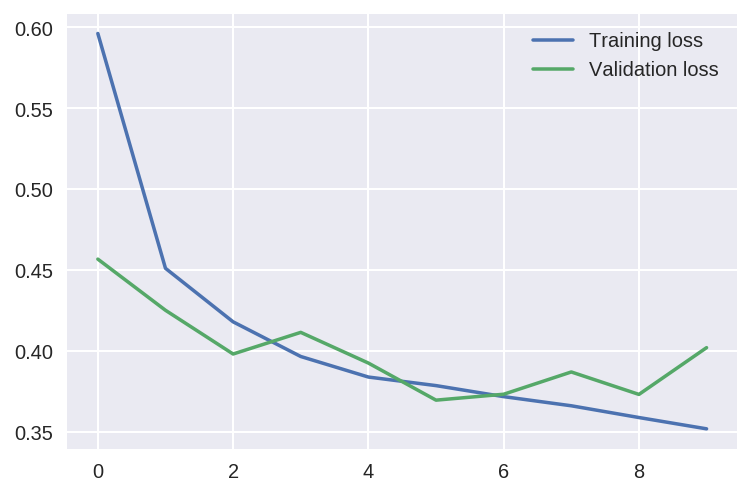

In [30]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

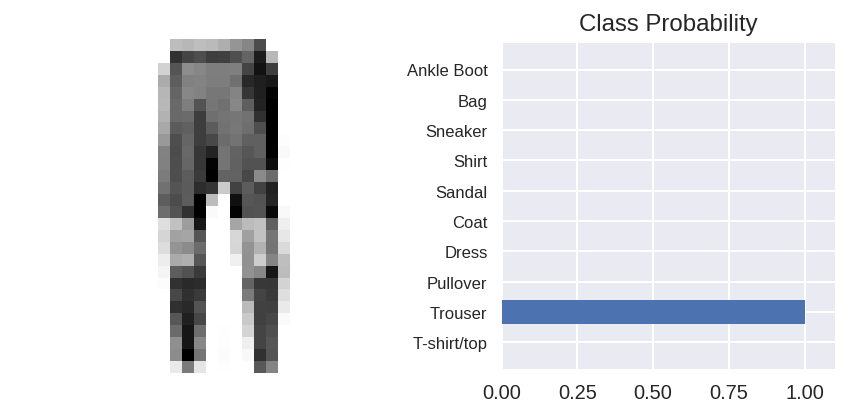

In [35]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')